In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
load_dotenv()
dataset_path=os.getenv("PROCESSED_ADNI_DATASET")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,1140,0,84.5123,1,25.0,0.150000,169.300000,0.610000,223.340000,36.000000,...,227.925000,0.495000,223.250000,27.445000,665.065000,2.725000,-516.185000,2.638340,2397.0,3164.85
1,1051,1,75.3699,1,26.0,0.097733,175.103337,0.562332,197.321714,42.533788,...,222.355754,0.500577,218.584302,30.381415,651.981453,3.154282,2595.481588,3.146500,1662.5,2648.30
2,15,0,80.9068,0,29.0,0.100000,161.280000,0.540000,174.530000,35.940000,...,221.760000,0.445000,NaN,30.565000,NaN,3.120000,4287.780000,2.897730,2188.0,3602.50
3,680,0,77.8932,0,28.0,0.110000,235.890000,0.510000,231.560000,41.660000,...,217.450000,0.540000,236.750000,30.465000,729.545000,3.010000,-741.895000,2.734850,2292.5,3267.45
4,324,1,75.3534,1,24.0,0.140000,192.290000,0.550000,218.500000,35.280000,...,269.565000,0.390000,219.405000,26.560000,608.050000,2.565000,456.550000,2.444245,1082.0,2550.50


Split a dataset into training and testing sets **at the subject level**, 
ensuring no subject appears in both sets. The split is stratified 
based on each subject's first diagnosis to preserve class distribution. 
Returns X_train, X_test, y_train, y_test.

In [ ]:
def subject_train_test_split(dataset):

    subjects = dataset["RID"].unique()
    first_diag_per_subject = dataset.groupby("RID")["Diagnosis"].first()

    train_subs, test_subs = train_test_split(
        subjects,
        test_size = 0.3,
        random_state = 42,
        stratify=first_diag_per_subject
    )

    train_df = dataset[dataset["RID"].isin(train_subs)].copy()
    test_df = dataset[dataset["RID"].isin(test_subs)].copy()

    X_train = train_df.drop(columns=["Diagnosis"])
    X_test = test_df.drop(columns=["Diagnosis"])
    y_train = train_df["Diagnosis"]
    y_test = test_df["Diagnosis"]

    overlap_subjects = set(train_df["RID"]).intersection(set(test_df["RID"]))
    if len(overlap_subjects) == 0:
        print("No subjects appear in both train and test sets.")
    else:
        print(f"Overlapping subjects found: {overlap_subjects}")

    print(f"Number of subjects in train: {len(train_df["RID"].unique())}")
    print(f"Number of subjects in test: {len(test_df["RID"].unique())}")

    return X_train, X_test, y_train, y_test


No subjects appear in both train and test sets.
Number of subjects in train: 359
Number of subjects in test: 155


In [ ]:
X_train, X_test, y_train, y_test = subject_train_test_split(dataset)

In [ ]:
def initiate_mice_imputation(X_train, X_test, y_train, y_test):

    imputers = {
        "bayes": BayesianRidge(),
        "knn": KNeighborsRegressor(),
        "nonLin": DecisionTreeRegressor(),
        "missForest": ExtraTreesRegressor()
    }
    
    imputed_data = {}

    for name, estimator in imputers.items():
        imputer = IterativeImputer(estimator=estimator, 
                                   random_state=42)
        imputer.fit(X_train)
        
        X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
        X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
        
        imputed_data[name] = (X_train_imp, X_test_imp)

    return imputed_data

In [8]:
dataframes = [
    X_train_bayes_t, X_test_bayes_t, 
    X_train_knn_t, X_test_knn_t,
    X_train_nonLin_t, X_test_nonLin_t,
    X_train_missForest_t, X_test_missForest_t,
]

for df in dataframes:
    if df.isna().any().all() == False:
        print("No missing values in any dataframe")
        break
    else:
        print("Still missing values")

No missing values in any dataframe


In [9]:
from sklearn.preprocessing import StandardScaler

cols = [
    'HipsASMbaseline', 'HipsContrastbaseline', 'HipsCorelationbaseline',
    'HipsVariancebaseline', 'HipsSumAveragebaseline', 'HipsSumVariancebaseline',
    'HipsEntropybaseline', 'HipsClusterShadebaseline', 'ERCsASMbaseline',
    'ERCsContrastbaseline', 'ERCsCorelationbaseline', 'ERCsVariancebaseline',
    'ERCsSumAveragebaseline', 'ERCsSumVariancebaseline', 'ERCsEntropybaseline',
    'ERCsClusterShadebaseline', 'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
    'HipposcampusVolumebaseline'
]

scaler = StandardScaler()

# X_train_bayes_t
X_train_bayes_t[cols] = scaler.fit_transform(X_train_bayes_t[cols])

# X_test_bayes_t
X_test_bayes_t[cols] = scaler.transform(X_test_bayes_t[cols])

# X_train_knn_t
X_train_knn_t[cols] = scaler.fit_transform(X_train_knn_t[cols])

# X_test_knn_t
X_test_knn_t[cols] = scaler.transform(X_test_knn_t[cols])

# X_train_nonLin_t
X_train_nonLin_t[cols] = scaler.fit_transform(X_train_nonLin_t[cols])

# X_test_nonLin_t
X_test_nonLin_t[cols] = scaler.transform(X_test_nonLin_t[cols])

# X_train_missForest_t
X_train_missForest_t[cols] = scaler.fit_transform(X_train_missForest_t[cols])

# X_test_missForest_t
X_test_missForest_t[cols] = scaler.transform(X_test_missForest_t[cols])


### Stratified Cross-Validation


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score, make_scorer
import numpy as np

def run_random_forest(classifier_name, imp_method, X_train, y_train):

        # Initialize the Random Forest with class weight balancing
        rf = RandomForestClassifier(n_estimators=100,
                                    max_depth=5,
                                    random_state=42,
                                    class_weight="balanced",
        )
        
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        metrics = {"accuracy": make_scorer(accuracy_score),
                   "balanced_accuracy": make_scorer(balanced_accuracy_score),  
                   "precision": make_scorer(precision_score, average="weighted"), 
                   "recall": make_scorer(recall_score, average="weighted"), 
                   "f1_weighted": make_scorer(f1_score, average="weighted"),
                   "roc_auc_ovr_weighted": make_scorer(roc_auc_score, 
                                                       average="weighted", 
                                                       multi_class="ovr", 
                                                       response_method="predict_proba",),
        }
        
        cross_val_results = cross_validate(rf,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring=metrics,
                                           return_train_score=True,
        )
                
        metric_names = list(metrics.keys())
        mean_train = [round(np.mean(cross_val_results[f"train_{metric}"]), 3) for metric in metric_names]
        std_train = [round(np.std(cross_val_results[f"train_{metric}"]), 3) for metric in metric_names]
        mean_test = [round(np.mean(cross_val_results[f"test_{metric}"]), 3) for metric in metric_names]
        std_test = [round(np.std(cross_val_results[f"test_{metric}"]), 3) for metric in metric_names]
        time = round(np.mean(cross_val_results[f"fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Classifier": classifier_name,
                "Imputation": imp_method,
                "Fit Time": time,
                "Metric": metric_names,
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = rf.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [11]:
bayes_model, bayes_metrics = run_random_forest("Random Forest", "Ridge Bayes", X_train_bayes_t, y_train)
knn_model, knn_metrics = run_random_forest("Random Forest", "KNN Reg", X_train_knn_t, y_train)
nonLin_model, nonLin_metrics = run_random_forest("Random Forest", "NonLin", X_train_nonLin_t, y_train)
missForest_model, missForest_metrics = run_random_forest("Random Forest", "MissForest", X_train_missForest_t, y_train)

In [12]:
validation_df = pd.concat([bayes_metrics, knn_metrics, nonLin_metrics, missForest_metrics])
validation_df_report = validation_df.set_index(["Classifier", "Imputation", "Fit Time", "Metric"])
validation_df_report

Mean Train  \
Classifier    Imputation  Fit Time Metric                             
Random Forest Ridge Bayes 0.358    accuracy                   0.909   
                                   balanced_accuracy          0.913   
                                   precision                  0.912   
                                   recall                     0.909   
                                   f1_weighted                0.907   
                                   roc_auc_ovr_weighted       0.990   
              KNN Reg     0.365    accuracy                   0.914   
                                   balanced_accuracy          0.917   
                                   precision                  0.916   
                                   recall                     0.914   
                                   f1_weighted                0.912   
                                   roc_auc_ovr_weighted       0.991   
              NonLin      0.307    accuracy                   0.909   
                                   balanced_accuracy          0.912   
                                   precision                  0.912   
                                   recall                     0.909   
                                   f1_weighted                0.907   
                                   roc_auc_ovr_weighted       0.989   
              MissForest  0.312    accuracy                   0.909   
                                   balanced_accuracy          0.913   
                                   precision                  0.912   
                                   recall                     0.909   
                                   f1_weighted                0.908   
                                   roc_auc_ovr_weighted       0.990   

                                                         Std Train  Mean Test  \
Classifier    Imputation  Fit Time Metric                                       
Random Forest Ridge Bayes 0.358    accuracy                  0.009      0.757   
                                   balanced_accuracy         0.008      0.764   
                                   precision                 0.008      0.765   
                                   recall                    0.009      0.757   
                                   f1_weighted               0.009      0.753   
                                   roc_auc_ovr_weighted      0.001      0.879   
              KNN Reg     0.365    accuracy                  0.007      0.724   
                                   balanced_accuracy         0.007      0.733   
                                   precision                 0.007      0.735   
                                   recall                    0.007      0.724   
                                   f1_weighted               0.008      0.719   
                                   roc_auc_ovr_weighted      0.001      0.872   
              NonLin      0.307    accuracy                  0.009      0.746   
                                   balanced_accuracy         0.008      0.752   
                                   precision                 0.008      0.754   
                                   recall                    0.009      0.746   
                                   f1_weighted               0.009      0.740   
                                   roc_auc_ovr_weighted      0.001      0.881   
              MissForest  0.312    accuracy                  0.009      0.752   
                                   balanced_accuracy         0.008      0.756   
                                   precision                 0.008      0.762   
                                   recall                    0.009      0.752   
                                   f1_weighted               0.009      0.746   
                                   roc_auc_ovr_weighted      0.001      0.875   

                                                         Std Test  
Classifier    Imputation  Fit Time 

### Evaluate

In [14]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [15]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [16]:
import time

def eval_random_forest(classifier_name, imp_method, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time

        # Bootstrap functions
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=100,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 

        
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Classifier": classifier_name,
                "Imputation": imp_method,
                "Classification Time": round(elapsed_time, 3),
                "Metric": metrics_train.keys(),
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
    })
        
        return pred_metrics_df

In [17]:
pred_bayes = eval_random_forest("Random Forest", "Ridge Bayes", bayes_model, X_train_bayes_t, X_test_bayes_t, y_train, y_test)
pred_knn = eval_random_forest("Random Forest", "KNN Reg", knn_model, X_train_knn_t, X_test_knn_t, y_train, y_test)
pred_nonLin = eval_random_forest("Random Forest", "NonLin", nonLin_model, X_train_nonLin_t, X_test_nonLin_t, y_train, y_test)
pred_missForest = eval_random_forest("Random Forest", "MissForest", missForest_model, X_train_missForest_t, X_test_missForest_t, y_train, y_test)

In [22]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def plot_imputer_roc(models_dict, X_tests, y_test, show_per_class=False):
    """
    Plot ROC curves per imputation method using sklearn's roc_auc_score for macro-AUC.
    
    Args:
        models_dict (dict): Dictionary of models {imputer_name: trained_model}
        X_tests (dict): Dictionary of test sets {imputer_name: X_test}
        y_test (array-like): True labels
        show_per_class (bool): Whether to plot ROC for each class
    """
    classes = sorted(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=classes)  # One-hot encode
    
    plt.figure(figsize=(8,6))
    
    for imp, model in models_dict.items():
        X_test = X_tests[imp]
        y_proba = model.predict_proba(X_test)
        
        # Compute per-class ROC
        fpr = dict()
        tpr = dict()
        aucs = []
        for i in range(len(classes)):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            aucs.append(auc(fpr[i], tpr[i]))
            
            # Optional: plot per-class curve
            if show_per_class:
                plt.plot(fpr[i], tpr[i], linestyle='--', alpha=0.3, label=f'{imp} - Class {classes[i]}')
        
        # Compute official macro-AUC using sklearn
        auc_macro = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
        
        # Compute macro-average TPR for smooth plotting
        fpr_macro = np.linspace(0, 1, 100)
        tpr_macro = np.mean([np.interp(fpr_macro, fpr[i], tpr[i]) for i in range(len(classes))], axis=0)
        
        plt.plot(fpr_macro, tpr_macro, linewidth=2, label=f'{imp} (AUC={auc_macro:.3f})')
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves per Imputer (ADNI-1)")
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()


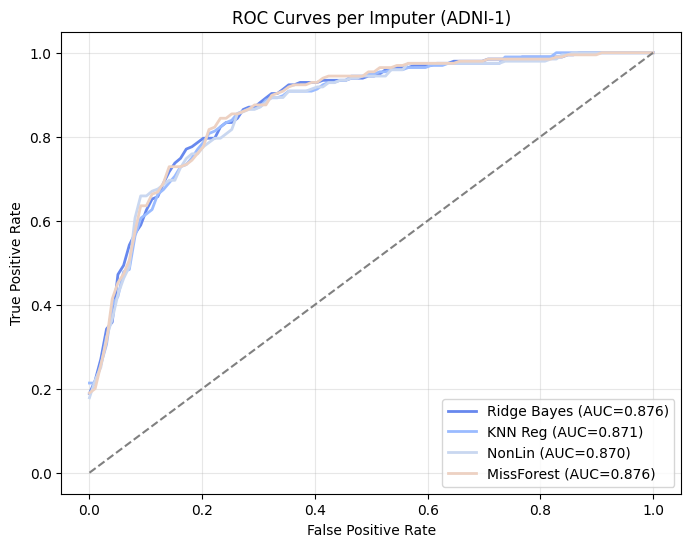

In [23]:
models_dict = {
    "Ridge Bayes": bayes_model,
    "KNN Reg": knn_model,
    "NonLin": nonLin_model,
    "MissForest": missForest_model
}

X_tests = {
    "Ridge Bayes": X_test_bayes_t,
    "KNN Reg": X_test_knn_t,
    "NonLin": X_test_nonLin_t,
    "MissForest": X_test_missForest_t
}

plot_imputer_roc(models_dict, X_tests, y_test)

In [20]:
prediction_df = pd.concat([pred_bayes, pred_knn, pred_nonLin, pred_missForest])
prediction_df_report = prediction_df.set_index(["Classifier", "Imputation",	"Classification Time", "Metric"])
prediction_df_report

Train data  \
Classifier    Imputation  Classification Time Metric                          
Random Forest Ridge Bayes 0.347               accuracy                0.886   
                                              balanced_accuracy       0.889   
                                              precision_macro         0.889   
                                              recall_macro            0.889   
                                              f1_macro                0.887   
                                              roc_auc_macro           0.987   
                                              specificity_macro       0.942   
              KNN Reg     0.079               accuracy                0.899   
                                              balanced_accuracy       0.903   
                                              precision_macro         0.904   
                                              recall_macro            0.903   
                                              f1_macro                0.900   
                                              roc_auc_macro           0.988   
                                              specificity_macro       0.949   
              NonLin      0.084               accuracy                0.902   
                                              balanced_accuracy       0.906   
                                              precision_macro         0.907   
                                              recall_macro            0.906   
                                              f1_macro                0.903   
                                              roc_auc_macro           0.987   
                                              specificity_macro       0.950   
              MissForest  0.131               accuracy                0.905   
                                              balanced_accuracy       0.907   
                                              precision_macro         0.912   
                                              recall_macro            0.907   
                                              f1_macro                0.907   
                                              roc_auc_macro           0.987   
                                              specificity_macro       0.951   

                                                                 Test data  \
Classifier    Imputation  Classification Time Metric                         
Random Forest Ridge Bayes 0.347               accuracy               0.713   
                                              balanced_accuracy      0.728   
                                              precision_macro        0.713   
                                              recall_macro           0.728   
                                              f1_macro               0.719   
                                              roc_auc_macro          0.876   
                                              specificity_macro      0.850   
              KNN Reg     0.079               accuracy               0.682   
                                              balanced_accuracy      0.702   
                                              precision_macro        0.680   
                                              recall_macro           0.702   
                                              f1_macro               0.687   
                                              roc_auc_macro          0.871   
                                              specificity_macro      0.834   
              NonLin      0.084               accuracy               0.688   
                                              balanced_accuracy      0.708   
                                              precision_macro        0.685   
                                              recall_macro           0.708   
                                              f1_macro               0.691   
                                              roc_auc_ma